In [1]:
!unzip -q chest-xray-pneumonia.zip 

replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
import os

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import glob
import h5py
import shutil
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
import scipy as sp 

# Definiendo las rutas a las carpetas que contienen las imágenes de entrenamiento para las clases "NORMAL" y "PNEUMONIA"
train_normal_dir = '/chest_xray/train/NORMAL'
train_neumonia_dir = 'chest_xray/train/PNEUMONIA'


In [3]:
# Define path to the data directory
data_dir = Path('chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [4]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,chest_xray/train/PNEUMONIA/person356_virus_733...,1
1,chest_xray/train/NORMAL/NORMAL2-IM-0649-0001.jpeg,0
2,chest_xray/train/NORMAL/IM-0156-0001.jpeg,0
3,chest_xray/train/PNEUMONIA/person1036_virus_17...,1
4,chest_xray/train/PNEUMONIA/person417_bacteria_...,1


label
1    3875
0    1341
Name: count, dtype: int64


/Users/Omar/Desktop/PRO7/myvenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Omar/Desktop/PRO7/myvenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Omar/Desktop/PRO7/myvenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


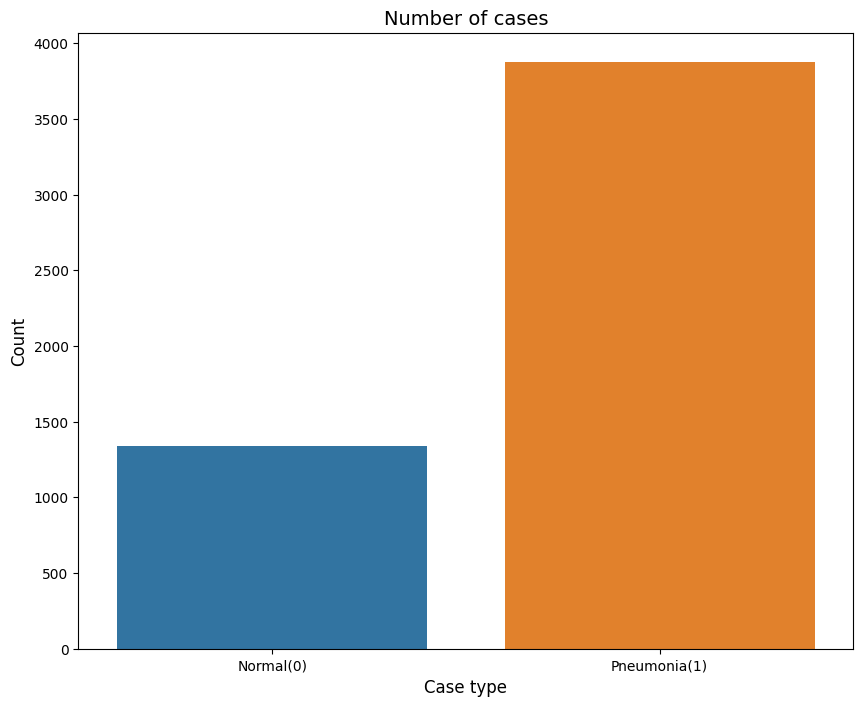

In [5]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

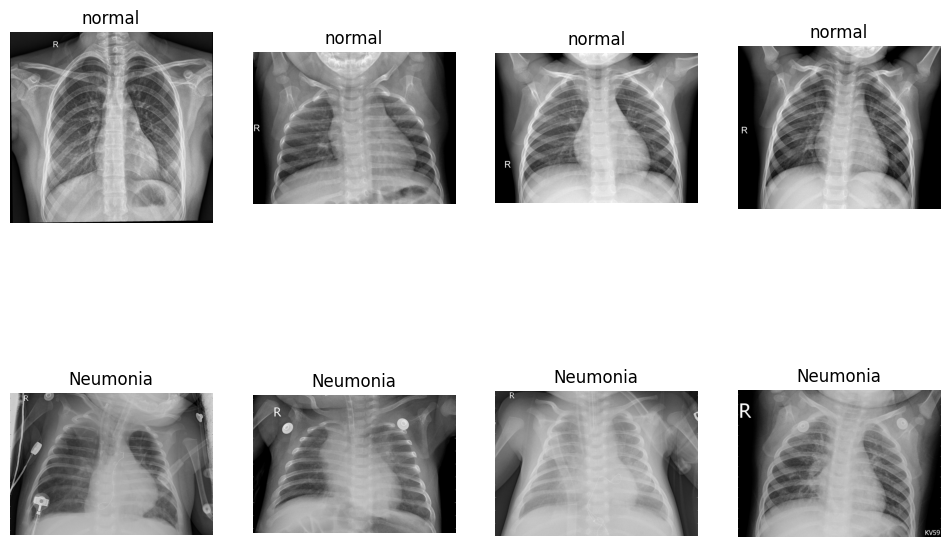

In [6]:
train_normal_dir = 'chest_xray/train/NORMAL'

# Obteniendo la lista de nombres de las imágenes normales
imagenes_normales = os.listdir(train_normal_dir)

# Configurando el tamaño de la figura para visualizar las imágenes
plt.figure(figsize=(12,8))

# Mostrando las primeras 4 imágenes normales
for i, img_name in enumerate(imagenes_normales[:4]) :
  img_path = os.path.join(train_normal_dir, img_name)
  imagen = cv2.imread(img_path)
  plt.subplot(2, 4, i+1)
  plt.imshow(imagen)
  plt.title("normal")
  plt.axis('off')

# Obteniendo la lista de nombres de las imágenes con neumonía
imagenes_neumonia = os.listdir(train_neumonia_dir)

# Mostrando las primeras 4 imágenes con neumonía
for i, img_name in enumerate(imagenes_neumonia[:4]) :
  img_path = os.path.join(train_neumonia_dir, img_name)
  imagen = cv2.imread(img_path)
  plt.subplot(2, 4, i+5)
  plt.imshow(imagen)
  plt.title("Neumonia")
  plt.axis('off')

In [7]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
import numpy as np
from sklearn.decomposition import PCA
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, RandomTranslation, RandomContrast, RandomBrightness
from keras.optimizers import Adam

2023-09-01 17:03:54.943976: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:

# Creando un generador de imágenes que normalizará las imágenes y dividirá los datos en conjuntos de entrenamiento y validación
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Configurando el generador para cargar imágenes desde el directorio de entrenamiento con un tamaño objetivo y otros parámetros
train_generator = train_datagen.flow_from_directory('chest_xray/train',
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    subset="training",
                                                    interpolation='nearest',
                                                    keep_aspect_ratio=False
                                                   )


Found 4173 images belonging to 2 classes.


In [9]:

# Configurando el generador de validación
validation_generator = train_datagen.flow_from_directory('chest_xray/train',
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    subset="validation")

Found 1043 images belonging to 2 classes.


In [10]:
# Creando la arquitectura del modelo de red neuronal convolucional (CNN)
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(512, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

In [23]:
import joblib
joblib.dump(model, 'model.pkl')

['model.pkl']

In [11]:
# Compilando el modelo con un optimizador, una función de pérdida y métricas para evaluar
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])



In [12]:
import scipy 


history = model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
131/131 [==============================] - 255s 2s/step - loss: 0.5964 - accuracy: 0.7395 - val_loss: 0.5141 - val_accuracy: 0.7430
Epoch 2/5
131/131 [==============================] - 229s 2s/step - loss: 0.2857 - accuracy: 0.8773 - val_loss: 0.2074 - val_accuracy: 0.9223
Epoch 3/5
131/131 [==============================] - 230s 2s/step - loss: 0.1470 - accuracy: 0.9420 - val_loss: 0.1394 - val_accuracy: 0.9540
Epoch 4/5
131/131 [==============================] - 223s 2s/step - loss: 0.1008 - accuracy: 0.9595 - val_loss: 0.1052 - val_accuracy: 0.9569
Epoch 5/5
131/131 [==============================] - 224s 2s/step - loss: 0.0722 - accuracy: 0.9712 - val_loss: 0.1054 - val_accuracy: 0.9636


In [22]:
import joblib
joblib.dump(history, 'history.pkl')

['history.pkl']

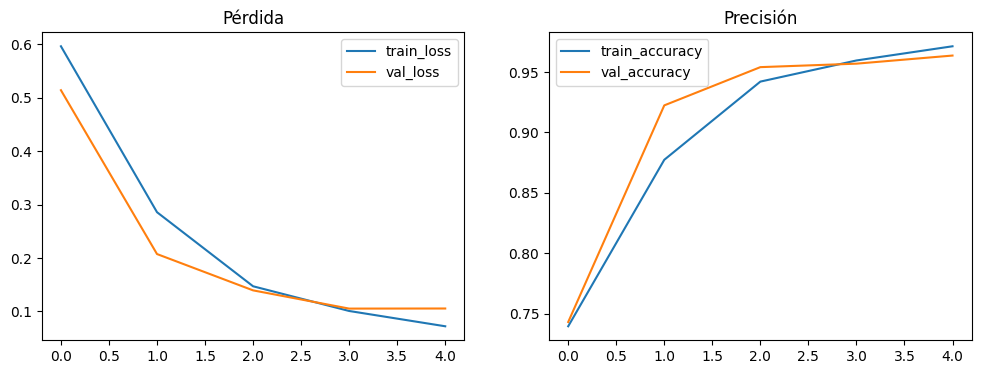

In [13]:
# Generar gráficas de pérdida y precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Pérdida')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Precisión')
plt.show()


In [15]:
# Creando un generador de imágenes para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory('chest_xray/test',
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

# Evaluando el modelo en el conjunto de prueba
perdida, accuracy = model.evaluate(test_generator)

# Imprimiendo la pérdida y precisión del modelo en el conjunto de prueba
print(perdida, accuracy)

Found 624 images belonging to 2 classes.


20/20 [==============================] - 15s 700ms/step - loss: 0.6284 - accuracy: 0.7997
0.6283860206604004 0.7996794581413269


1/1 [==============================] - 0s 232ms/step


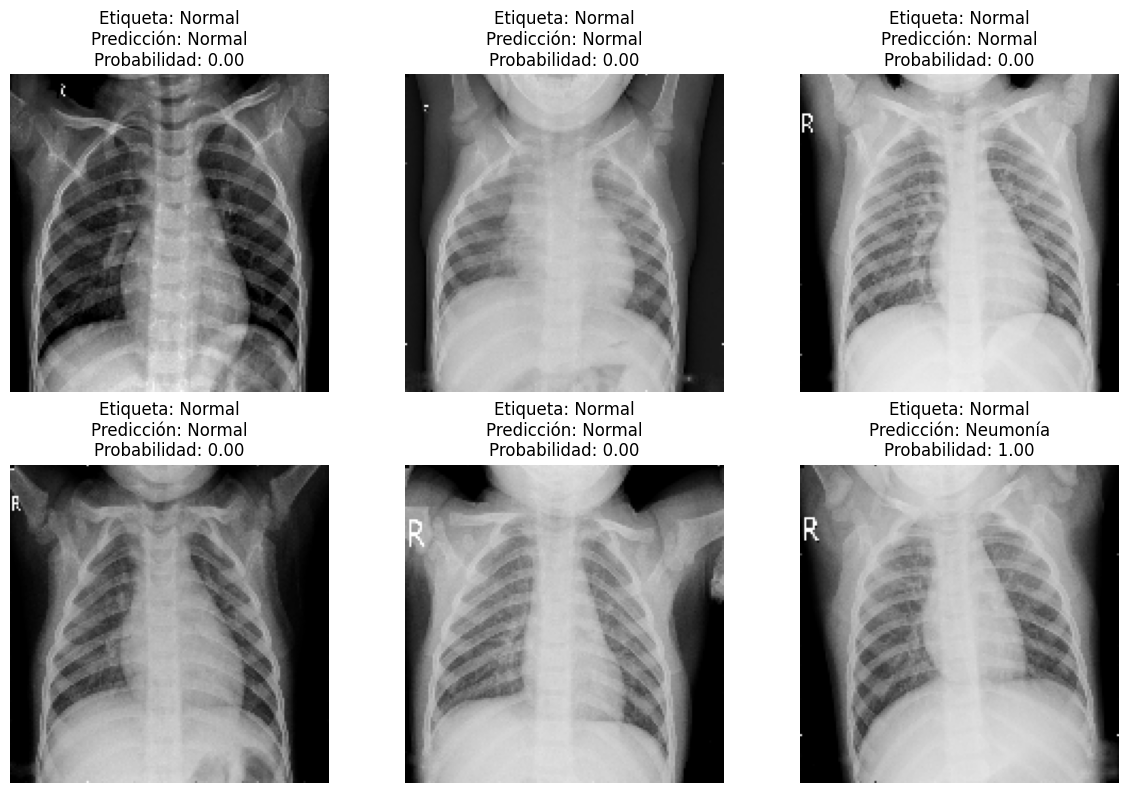

In [16]:
val_images_dir = 'chest_xray/val/NORMAL'
val_image_names = os.listdir(val_images_dir)

plt.figure(figsize=(12, 8))

for i, img_name in enumerate(val_image_names[:6]):
    img_path = os.path.join(val_images_dir, img_name)
    image = cv2.imread(img_path)
    if image is None:
        print(f"Failed to load image: {img_path}")
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (150, 150))
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)
    predicted_class = "Normal" if prediction[0][0] < 0.5 else "Neumonía"
    prediction_prob = prediction[0][0]

    plt.subplot(2, 3, i + 1)
    plt.imshow(image[0])
    plt.title(f"Etiqueta: Normal\nPredicción: {predicted_class}\nProbabilidad: {prediction_prob:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 28ms/step


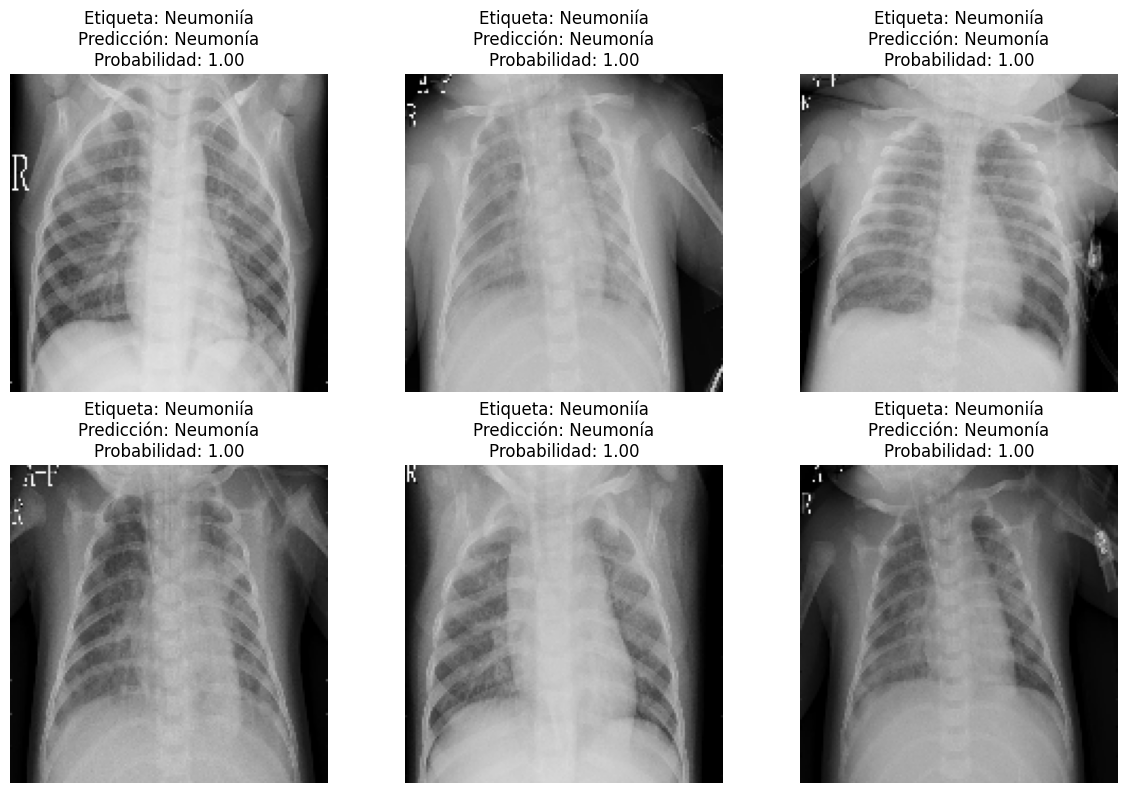

In [17]:
val_images_dir = 'chest_xray/val/PNEUMONIA'
val_image_names = os.listdir(val_images_dir)

plt.figure(figsize=(12, 8))

for i, img_name in enumerate(val_image_names[:6]):
    img_path = os.path.join(val_images_dir, img_name)
    image = cv2.imread(img_path)
    if image is None:
        print(f"Failed to load image: {img_path}")
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (150, 150))
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)
    predicted_class = "Normal" if prediction[0][0] < 0.5 else "Neumonía"
    prediction_prob = prediction[0][0]

    plt.subplot(2, 3, i + 1)
    plt.imshow(image[0])
    plt.title(f"Etiqueta: Neumoniía\nPredicción: {predicted_class}\nProbabilidad: {prediction_prob:.2f}") #aquí me había equivocado y puse normalpor eso en las imagenes aparece normal ajajjaajaja
    plt.axis('off')

plt.tight_layout()
plt.show()

In [18]:
val_base_dir = 'chest_xray/test'
class_names = ["NORMAL", "PNEUMONIA"]

true_labels = []
predicted_labels = []

for class_name in class_names:
    class_dir = os.path.join(val_base_dir, class_name)
    val_image_names = os.listdir(class_dir)

    for img_name in val_image_names:
        img_path = os.path.join(class_dir, img_name)
        image = cv2.imread(img_path)
        if image is None:
            print(f"Failed to load image: {img_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (150, 150))
        image = np.expand_dims(image, axis=0)

        prediction = model.predict(image)
        predicted_class = class_names[int(prediction[0][0] > 0.5)]  # Convierte valor a 0 o 1 usando un umbral de 0.5
        true_class = class_name

        true_labels.append(true_class)
        predicted_labels.append(predicted_class)

1/1 [==============================] - 0s 27ms/step


In [19]:
#reporte de clasificación
from sklearn.metrics import classification_report, confusion_matrix

class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Reporte de Clasificación:\n", class_report)

Reporte de Clasificación:
               precision    recall  f1-score   support

      NORMAL       0.82      0.64      0.72       234
   PNEUMONIA       0.81      0.92      0.86       390

    accuracy                           0.81       624
   macro avg       0.82      0.78      0.79       624
weighted avg       0.81      0.81      0.81       624



In [20]:
# Generar la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=class_names)
print("Matriz de Confusión:\n", conf_matrix)

Matriz de Confusión:
 [[149  85]
 [ 32 358]]


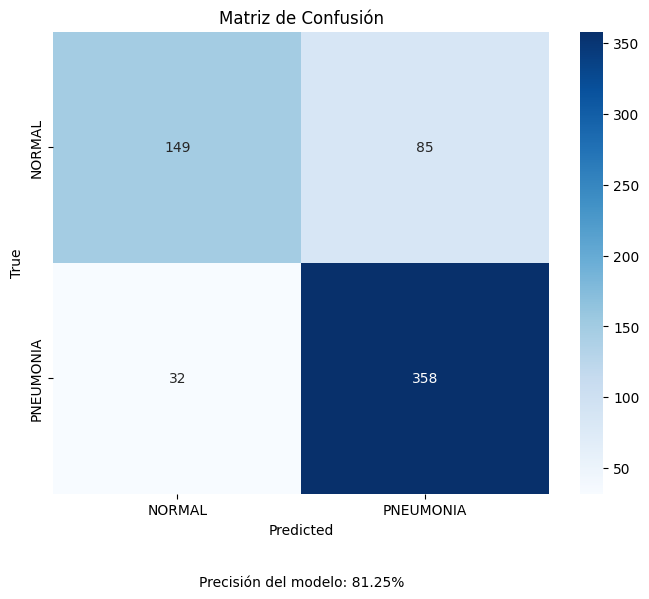

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Generar la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Calcular la precisión
accuracy = accuracy_score(true_labels, predicted_labels)
accuracy_percent = accuracy * 100

# Crear una figura y un eje para la gráfica de matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión")
plt.xlabel("Predicted")
plt.ylabel("True")

# Mostrar la precisión en la gráfica
plt.text(0.5, -0.2, f"Precisión del modelo: {accuracy_percent:.2f}%", ha="center", transform=plt.gca().transAxes)

plt.show()